# Пакеты

In [ ]:
# Hugging Face tokenizers
from tokenizers import Tokenizer, decoders
from tokenizers.models import BPE, WordPiece
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.normalizers import Lowercase
from tokenizers.trainers import BpeTrainer, WordPieceTrainer
from tokenizers.processors import TemplateProcessing

# Word2vec
import gensim
from gensim.models import Word2Vec,KeyedVectors

# torch
import torch
from torch import nn
from torch.utils.data import DataLoader


import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Получить датасет из kaggle

In [ ]:
!mkdir -p ~/.kaggle
!echo '{"username":"goshaserbin","key":""}' > ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d goshaserbin/movies
!unzip movies

100% 43.8M/43.8M [00:01<00:00, 40.7MB/s]
100% 43.8M/43.8M [00:01<00:00, 33.1MB/s]
Archive:  movies.zip
  inflating: movies large.csv        
  inflating: movies mini.csv         
  inflating: movies.csv              
  inflating: reviews large.csv       
  inflating: reviews mini.csv        
  inflating: reviews.csv             
  inflating: validation.csv          


In [ ]:
movie_df = pd.read_csv("movies large.csv")
review_df = pd.read_csv("reviews large.csv")

In [ ]:
val_df = pd.read_csv("validation.csv")
val_df['movieId'] = pd.merge(val_df, movie_df, left_on='movieName', right_on='name', how='left')['id']

# Анализ данных

In [ ]:
len(review_df.movieId.unique())

2152

In [ ]:
movie_df

In [ ]:
review_df

,id,movieId,title,type,review,author,authorId
0,3324223,326,Главным героем всё это время был не Энди Дюфрейн,Позитивный,"Говоря про фильм «Побег из Шоушенка», то я все...",HochuHollywood,1453824.0
1,3323034,5019944,Даешь работу плутонянининанам! (хе-хе),Позитивный,Очень понравилась концовка. Очень не понравило...,bluebellaza,1084607.0
2,3322706,5019944,Новый взгляд на фантастику — Кибердеревня!,Позитивный,"Неожиданно классный сериал, сочетающий в себе ...",a.smirnova@creagames.ru,18658956.0
3,3322405,5019944,Растеряли все полимеры,Нейтральный,"Начался сериал бодренько, и серии до пятой я н...",mega-linch,31270117.0
4,3322252,5019944,Марсианский кукумбер увидел большой экран,Позитивный,"Думаю, многие видели короткие ролики, появивши...",barrels-n-bullets,21221018.0
...,...,...,...,...,...,...,...
12495,2958066,817509,реально крутой сериал,Позитивный,"На самом деле, редко советую кому нормальный с...",Александр Болсуновский - 1520,61330771.0
12496,2958038,412248,"Рецензия на фильм Все умрут, а я останусь",Позитивный,У всех разные ассоциации и воспоминания о школ...,danayassin,65077609.0
12497,2958010,1190387,Смерть во имя жизни.,Позитивный,"Очень странно, что рейтинг настолько низкий. М...",Очарованный_странник,14153751.0
12498,2957997,412248,"Осуждать нельзя, понять",Позитивный,"Кажется, что конфликт между родителями и детьм...",Anel Kemeshova,63175641.0


In [ ]:
val_df

,review,movieName,movieId
0,Это аниме повествует об атаке гигантских челов...,Атака титанов,749374
1,В этом биографическом фильме рассказывается о ...,Богемская рапсодия,568289
2,"История про человека, который решил кардинальн...",Бойцовский клуб,361
3,Добрый мультик про робота-мусорщика и несерьез...,ВАЛЛ·И,279102
4,Фильм-биография про брокера. В фильме большое ...,Волк с Уолл-стрит,462682
5,Фильм по известной серии книг про особенного р...,Гарри Поттер и философский камень,689
6,"Старый фильм по книге Стивена Кинга, в котором...",Зеленая миля,435
7,В недалеком будущем наша планета стала практич...,Интерстеллар,258687
8,"Фильм по книге. Рассказана история детектива, ...",Остров проклятых,397667
9,Актер из человека паука в фильме про войну,По соображениям совести,649917


In [ ]:
index = 0
print(movie_df.name[index])
print(movie_df.description[index])
print(movie_df.shortDescription[index])

1+1
Пострадав в результате несчастного случая, богатый аристократ Филипп нанимает в помощники человека, который менее всего подходит для этой работы, – молодого жителя предместья Дрисса, только что освободившегося из тюрьмы. Несмотря на то, что Филипп прикован к инвалидному креслу, Дриссу удается привнести в размеренную жизнь аристократа дух приключений.
Аристократ на коляске нанимает в сиделки бывшего заключенного. Искрометная французская комедия с Омаром Си


In [ ]:
review_df[review_df.movieId == movie_df.id[index]].review.values[0]

'С уверенностью могу сказать, что это один из самых лучших фильмов современного кинематографа. Потрясающая история дружбы, которая проходит через время, боль, утрату, препятствия, но все равно сохраняет свою теплоту и доверие.  Клевый сюжет, который так или иначе затрагивает тему социального и финансового неравенства. Яркие актеры, лучезарный Идрис не оставляет равнодушным. Фильм ярко демонстрирует, что ни смотря ни на что, даже казалось бы непоправимые обстоятельства, наше счастье зависит от нас самих, а так же от тех людей, которых мы выбрали себе в окружение.  Обычный человек может быть спасательным кругом в той или иной жизненной ситуации. Важное иметь таких людей и платить верностью, заботой и любовью. Здорово, что фильм снят на основе реальных событий-это заставляет верить в добро и маленькое волшебство.  Элементы роскошной жизни (дорогие автомобили, частные самолёты, классические концерты музыки) так же цепляют. Но так же фильм отражает мысль, что не все купишь за деньги. И скол

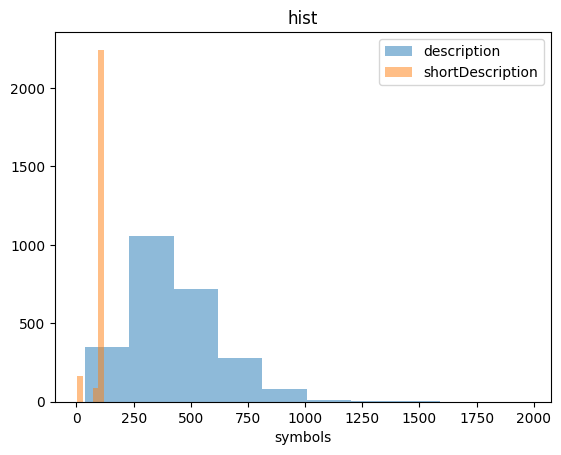

In [ ]:
plt.hist(movie_df.description.str.len(), alpha=0.5, label='description')
plt.hist(movie_df.shortDescription.str.len(), alpha=0.5, label='shortDescription', bins = 5)
plt.xlabel('symbols')
plt.title('hist')
plt.legend(loc='upper right')
plt.show()

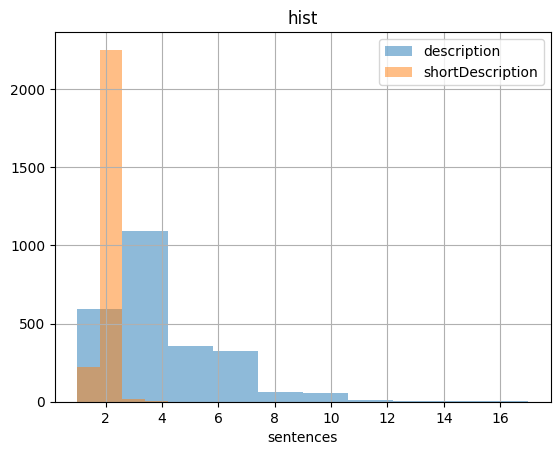

In [ ]:
movie_df.description.apply(lambda text: len(str(text).rstrip(".").split("."))).hist(alpha=0.5, label='description')
movie_df.shortDescription.apply(lambda text: len(str(text).rstrip(".").split("."))).hist(alpha=0.5, label='shortDescription', bins = 5)
plt.xlabel('sentences')
plt.title('hist')
plt.legend(loc='upper right')
plt.show()

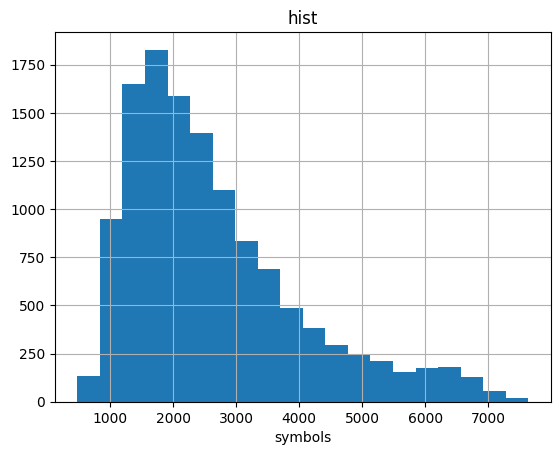

In [ ]:
review_df.review.str.len().hist(bins=20)
plt.xlabel('symbols')
plt.title('hist')
plt.show()

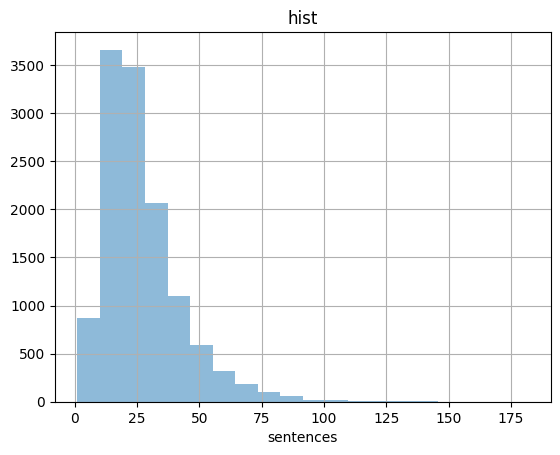

In [ ]:
review_df.review.apply(lambda text: len(str(text).rstrip(".").split("."))).hist(alpha=0.5, label='description',bins=20)
plt.xlabel('sentences')
plt.title('hist')
plt.show()

# Токенизатор

In [ ]:
tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))
trainer = WordPieceTrainer(special_tokens=["[UNK]"])
tokenizer.pre_tokenizer = Whitespace()
tokenizer.normalizer = Lowercase()

In [ ]:
tokenizer.train_from_iterator(review_df.review.values, trainer=trainer)
tokenizer.decoder = decoders.WordPiece()

In [ ]:
vocab_size = tokenizer.get_vocab_size()
vocab_size

30000

In [ ]:
tokenized_review = [text.tokens for text in tokenizer.encode_batch(review_df.review.values)]
tokenized_shortDescription = [text.tokens for text in tokenizer.encode_batch(movie_df.description.values)]
tokenized_description = [text.tokens for text in tokenizer.encode_batch(movie_df.shortDescription.values)]

# Word2Vec Embedding

In [ ]:
embedding_size = 512
word2vec = gensim.models.Word2Vec(
    tokenized_review,
    vector_size=embedding_size,
    epochs = 3,
    min_count=1,
    window = 6,
    shrink_windows = 1,

)

In [ ]:
word2vec.wv.most_similar('женщина')

[('девочка', 0.9284723997116089),
 ('девушка', 0.9112789034843445),
 ('молодая', 0.8025418519973755),
 ('мама', 0.7888116240501404),
 ('героиня', 0.7851748466491699),
 ('мать', 0.7847239971160889),
 ('наша', 0.7730816006660461),
 ('семья', 0.7658632397651672),
 ('маленькая', 0.7630724906921387),
 ('подруга', 0.7525051236152649)]

# Dataset

In [ ]:
import nltk
nltk.download('punkt')

def split_review(review, limit = 3):
    # определяем количество предложений в обзоре
    sentences = nltk.sent_tokenize(review)
    num_sentences = len(sentences)

    # если количество предложений меньше или равно 10, то возвращаем исходный обзор
    if num_sentences <= limit:
        return [review]

    # иначе разбиваем обзор на несколько частей (не больше 10 предложений в каждой)
    split_reviews = []
    for i in range(0, num_sentences, limit):
        split_review = ' '.join(sentences[i:i+limit])
        split_reviews.append(split_review)

    return split_reviews

movieIds = []
reviews = []

# проходим по каждой строке и разбиваем обзоры, у которых длина больше 10 предложений
for index, row in tqdm.tqdm(review_df.iterrows(),total = len(review_df)):
    split_reviews = split_review(row['review'])

    # добавляем новые строки в новый датафрейм
    for review in split_reviews:
        movieIds.append(row['movieId'])
        reviews.append(review)
short_review_df = pd.DataFrame({'movieId' : movieIds, 'review' : reviews})


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|██████████| 12500/12500 [00:10<00:00, 1137.31it/s]


In [ ]:
short_review_df

,movieId,review
0,326,"Говоря про фильм «Побег из Шоушенка», то я все..."
1,326,"Это точно история Эллиса Бойда Реддинга, тем б..."
2,5019944,Очень понравилась концовка. Очень не понравило...
3,5019944,Поэтому я первые серии просто изнывала от того...
4,5019944,"Поэтому я страшно скучала, мечтая об ином угле..."
...,...,...
116731,933208,"Постарались, кстати, не только сценаристы и ак..."
116732,933208,"Особенно хочу отметить то, как команде проекта..."
116733,933208,"Тут речь не о том, кто добрый, а кто не очень...."
116734,933208,"Мне нравятся фильмы про отряды, команды и груп..."


In [ ]:
tokenized_short_review = [text.tokens for text in tokenizer.encode_batch(short_review_df.review.values)]

In [ ]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.tokenized_texts = tokenized_short_review

    def __len__(self):
        return len(self.tokenized_texts)

    def __getitem__(self, idx):
        positive_tokens = [word2vec.wv.get_vector(token) for token in self.tokenized_texts[idx]]

        movieId = short_review_df.iloc[idx].movieId
        movie_index = movie_df[movie_df.id == movieId].index[0]
        anchor_tokens = [word2vec.wv.get_vector(token) for token in tokenized_shortDescription[movie_index] if word2vec.wv.has_index_for(token)]

        negative_index = np.random.choice(movie_df[movie_df.id != movieId].index.values)
        negative_tokens = [word2vec.wv.get_vector(token) for token in tokenized_shortDescription[negative_index] if word2vec.wv.has_index_for(token)]

        return {
                'anchor' : torch.tensor(np.stack(anchor_tokens)),
                'positive' : torch.tensor(np.stack(positive_tokens)),
                'negative' : torch.tensor(np.stack(negative_tokens)),
            }



dataset = TextDataset()

In [ ]:
class SentenceLengthBatchSampler:
    def __init__(self, data_source, batch_size):
        self.data_source = data_source
        self.batch_size = batch_size
        self.sorted_indices = np.argsort([10000000*len(x['anchor'])+ 10000 * len(x['positive']) + len(x['negative']) for x in data_source])

    def __iter__(self):
        batches = []
        batch = []
        for idx in self.sorted_indices:
            batch.append(idx)
            if len(batch) == self.batch_size:
                batches.append(batch)
                batch = []
        if len(batch) > 0:
            batches.append(batch)
        np.random.shuffle(batches)
        return iter(batches)

    def __len__(self):
        return len(self.data_source) // self.batch_size


batch_sampler = SentenceLengthBatchSampler(dataset, batch_size=100)

In [ ]:
def collate_fn(batch):
    anchor_sizes = torch.tensor([t['anchor'].size(0) for t in batch]).to(device)
    pos_sizes = torch.tensor([t['positive'].size(0) for t in batch]).to(device)
    neg_sizes = torch.tensor([t['negative'].size(0) for t in batch]).to(device)
    vector_size = batch[0]['anchor'].size()[1:]
    new_batch = {
        'anchor' : torch.zeros(len(batch), torch.max(anchor_sizes), *vector_size),
        'positive' : torch.zeros(len(batch),  torch.max(pos_sizes), *vector_size),
        'negative' : torch.zeros(len(batch),  torch.max(neg_sizes), *vector_size),
    }

    for i, t in enumerate(batch):
        new_batch['anchor'][i, :anchor_sizes[i]] = t['anchor']
        new_batch['positive'][i, :pos_sizes[i]] = t['positive']
        new_batch['negative'][i, :neg_sizes[i]] = t['negative']
    return {'anchor' : (new_batch['anchor'].to(device),anchor_sizes),
            'positive': (new_batch['positive'].to(device),pos_sizes),
            'negative': (new_batch['negative'].to(device),neg_sizes),
            }

dataloader = DataLoader(dataset, batch_sampler=batch_sampler, collate_fn = collate_fn)

 # Triplet Loss

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, out_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.out_size = out_size

        self.x2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=False)
        self.h2y = nn.Linear(hidden_size, out_size, bias = False)
        self.f = nn.Tanh()

    def forward(self, x, actual_sequence_lens):
        # x : (batch_size, seq, input_size)
        batch_size = x.size(0)
        sequence_size = x.size(1)

        out = torch.zeros(batch_size,sequence_size, self.out_size).to(device)
        hidden = torch.zeros(batch_size, sequence_size + 1, self.hidden_size).to(device)
        for t in range(sequence_size):
            mask = actual_sequence_lens > t
            hidden[mask, t] = self.f(self.h2h(hidden[mask, t-1]) + self.x2h(x[mask, t]))
            out[mask, t] = self.h2y(hidden[mask, t])

        return out, hidden

    @torch.no_grad()
    def single_forward(self, x, hidden):
        new_hidden = self.f(self.h2h(hidden) + self.x2h(x))
        out = self.h2y(new_hidden)
        return out, new_hidden

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, out_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.out_size = out_size

        self.x2i = nn.Linear(input_size, hidden_size)
        self.h2i = nn.Linear(hidden_size, hidden_size, bias=False)
        self.p2i = nn.Linear(hidden_size, hidden_size, bias=False)

        self.x2f = nn.Linear(input_size, hidden_size)
        self.h2f = nn.Linear(hidden_size, hidden_size, bias=False)
        self.p2f = nn.Linear(hidden_size, hidden_size, bias=False)

        self.x2o = nn.Linear(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, hidden_size, bias = False)
        self.p2o = nn.Linear(hidden_size, hidden_size, bias=False)

        self.x2c = nn.Linear(input_size, hidden_size)
        self.h2c = nn.Linear(hidden_size, hidden_size, bias = False)

        self.h2y = nn.Linear(hidden_size, out_size)

        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x, actual_sequence_lens):
        # x : (batch_size, seq, input_size)
        batch_size = x.size(0)
        sequence_size = x.size(1)

        out = torch.zeros_like(x).to(device)
        hidden = torch.zeros(batch_size, sequence_size + 1, self.hidden_size).to(device)
        c = torch.ones(batch_size, self.hidden_size).to(device)
        for t in range(sequence_size):
            mask = actual_sequence_lens > t
            i = self.sigmoid(self.x2i(x[mask, t])+self.h2i(hidden[mask, t-1])+self.p2i(c[mask]))
            f = self.sigmoid(self.x2f(x[mask, t])+self.h2f(hidden[mask, t-1])+self.p2f(c[mask]))
            o = self.sigmoid(self.x2o(x[mask, t])+self.h2o(hidden[mask, t-1])+self.p2o(c[mask]))
            c_ = self.tanh(self.x2c(x[mask, t])+self.h2c(hidden[mask, t-1]))
            c[mask] = f * c[mask] + i * c_
            hidden[mask, t] = o * c[mask]
            out[mask, t] = self.h2y(hidden[mask, t])

        return out, hidden

    @torch.no_grad()
    def single_forward(self, x, hidden, c):
        i = self.sigmoid(self.x2i(x)+self.h2i(hidden)+self.p2i(c))
        f = self.sigmoid(self.x2f(x)+self.h2f(hidden)+self.p2f(c))
        o = self.sigmoid(self.x2o(x)+self.h2o(hidden)+self.p2o(c))
        c_ = self.tanh(self.x2c(x)+self.h2c(hidden))
        c = f * c + i * c_
        new_hidden = o * c
        out = self.h2y(new_hidden)
        return out, new_hidden

In [ ]:
# model = RNN(input_size = embedding_size, hidden_size = 4 * embedding_size, out_size = embedding_size).to(device)
model = LSTM(input_size = embedding_size, hidden_size = 4 * embedding_size, out_size = embedding_size).to(device)

In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        # вычисляем расстояния между anchor и positive
        pos_dist = torch.sum((anchor - positive) ** 2, dim=1)
        # вычисляем расстояния между anchor и negative
        neg_dist = torch.sum((anchor - negative) ** 2, dim=1)
        # вычисляем разницу между расстояниями и добавляем margin
        loss = torch.clamp(pos_dist - neg_dist + self.margin, min=0.0)
        # усредняем по батчу
        loss = torch.mean(loss)
        return loss

In [ ]:
criterion = TripletLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)

In [ ]:
num_epochs = 1
model.train()
losses = []
for epoch in range(num_epochs):
    for x in dataloader:

        input, sizes = x['anchor']
        anchor = model(input, sizes)[0]
        mask = torch.zeros_like(anchor).to(device)
        for i, size in enumerate(sizes):
            mask[i, size-1, :] = 1
        anchor = torch.masked_select(anchor, mask.bool()).view(sizes.size(0), anchor.size(2))

        input, sizes = x['positive']
        positive = model(input, sizes)[0]
        mask = torch.zeros_like(positive).to(device)
        for i, size in enumerate(sizes):
            mask[i, size-1, :] = 1
        positive = torch.masked_select(positive, mask.bool()).view(sizes.size(0), positive.size(2))

        input, sizes = x['negative']
        negative = model(input, sizes)[0]
        mask = torch.zeros_like(negative).to(device)
        for i, size in enumerate(sizes):
            mask[i, size-1, :] = 1
        negative = torch.masked_select(negative, mask.bool()).view(sizes.size(0), negative.size(2))

        # вычисление loss и обновление параметров
        loss = criterion(anchor, positive, negative)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(loss.item())
        losses.append(loss.item())

    print('Epoch: {}, Loss: {}'.format(epoch+1, loss.item()))

1.3751187324523926
1.062268853187561
0.9937022924423218
1.0302735567092896
1.114687204360962
0.9236009120941162
1.0316495895385742
1.1680501699447632
0.9043231010437012
0.8140391111373901
0.9436739087104797
0.8852713704109192
0.809345543384552
0.8821678757667542
0.9800962805747986
0.836603045463562
0.95984947681427
0.8250250220298767
1.0709704160690308
0.8350936770439148
1.004398226737976
0.8677142858505249
0.9613505601882935
0.8586573004722595
0.8520945310592651
0.7609959840774536
0.958389937877655
0.9272708892822266
0.7990262508392334
0.8257604837417603
0.8313899636268616
0.7706518173217773
0.7993806004524231
0.826384425163269
0.6777464151382446
0.9037438035011292
0.8388001322746277
0.6814776659011841
0.9829091429710388
0.9027935862541199
0.8278566002845764
0.8802501559257507
0.8320311307907104
0.7414631247520447
0.864338219165802
0.7537029981613159
0.6966772079467773
0.7336061000823975
0.8284457325935364
0.9396876096725464
0.8341618180274963
0.6211491823196411
0.9028214812278748
0.7

KeyboardInterrupt: ignored

In [ ]:
np.argmax(losses)

197

In [ ]:
losses[197] = 0

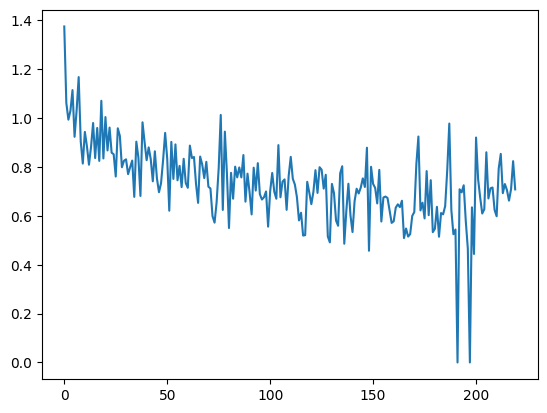

In [ ]:
plt.plot(losses)

# Prediction

In [ ]:
class MovieDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.tokenized_texts = tokenized_description
        self.tokenized_short_texts = tokenized_shortDescription

    def __len__(self):
        return len(self.tokenized_texts)

    def __getitem__(self, idx):
        num = np.random.randint(0,2)
        if num == 0:
            tokens = [word2vec.wv.get_vector(token) for token in self.tokenized_texts[idx] if word2vec.wv.has_index_for(token)]
        else:
            tokens = [word2vec.wv.get_vector(token) for token in self.tokenized_short_texts[idx] if word2vec.wv.has_index_for(token)]

        return torch.tensor(np.stack(tokens)), torch.zeros(len(self.tokenized_texts), dtype=torch.float).scatter_(0, torch.tensor(idx), value=1)



dataset = MovieDataset()

In [ ]:
class SentenceLengthBatchSampler2:
    def __init__(self, data_source, batch_size):
        self.data_source = data_source
        self.batch_size = batch_size
        self.sorted_indices = np.argsort([len(x[0]) for x in data_source])

    def __iter__(self):
        batches = []
        batch = []
        for idx in self.sorted_indices:
            batch.append(idx)
            if len(batch) == self.batch_size:
                batches.append(batch)
                batch = []
        if len(batch) > 0:
            batches.append(batch)
        np.random.shuffle(batches)
        return iter(batches)

    def __len__(self):
        return len(self.data_source) // self.batch_size


batch_sampler = SentenceLengthBatchSampler2(dataset, batch_size=650)

In [ ]:
def collate_fn2(batch):
    sizes = torch.tensor([t[0].size(0) for t in batch])
    vector_size = batch[0][0].size()[1:]
    new_batch = torch.zeros(len(batch), torch.max(sizes), *vector_size).to(device)
    y  = torch.zeros(len(batch), batch[0][1].size()[0]).to(device)

    for i, t in enumerate(batch):
        new_batch[i, :sizes[i]] = t[0]
        y[i] = t[1]
    return (new_batch,sizes), y

train_dataloader = DataLoader(dataset, batch_sampler=batch_sampler, collate_fn = collate_fn2)

In [ ]:
class NeuralPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, out_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Sigmoid(),
            nn.Linear(hidden_size, out_size)
        )

    def forward(self, x):
        return self.model(x)

class NeuralPredictor2(nn.Module):
    def __init__(self, input_size, out_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, out_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# predictor = NeuralPredictor(512,1024, len(movie_df)).to(device)
predictor = NeuralPredictor2(512, len(movie_df)).to(device)

In [ ]:
len(train_dataloader)

3

In [ ]:
losses = []

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

0

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(predictor.parameters(), lr=1e-4)

num_epochs = 10
predictor.train()
model.eval()
for epoch in range(num_epochs):
    for (x,sizes), y in train_dataloader:
        torch.cuda.empty_cache()
        gc.collect()
        embds= model(x,sizes)[0]
        mask = torch.zeros_like(embds).to(device)
        for i, size in enumerate(sizes):
            mask[i, size-1, :] = 1
        embds = torch.masked_select(embds, mask.bool()).view(sizes.size(0), embds.size(2)).detach()
        preds = predictor(embds)
        loss = criterion(preds, y)
        losses.append(loss.item())
        optimizer.zero_grad()
        print(loss.item())
        loss.backward()
        optimizer.step()
    print("EPOCH", np.mean(losses[-len(train_dataloader):]))

7.778099060058594
7.771467685699463
7.736356258392334
7.774189472198486
EPOCH 7.760671138763428
7.777592658996582
7.771753787994385
7.775105953216553
7.730635166168213
EPOCH 7.759164969126384
7.731576919555664
7.771774768829346
7.770578384399414
7.774937629699707
EPOCH 7.772430260976155
7.771008014678955
7.731616020202637
7.776102066040039
7.772103786468506
EPOCH 7.7599406242370605
7.774440765380859
7.736546516418457
7.772310733795166
7.7669196128845215
EPOCH 7.758592287699382
7.774590969085693
7.725471019744873
7.77056360244751
7.767079830169678
EPOCH 7.7543714841206866
7.772881984710693
7.731389045715332
7.773034572601318
7.768539905548096
EPOCH 7.757654507954915
7.767294883728027
7.730515956878662
7.774069786071777
7.770571231842041
EPOCH 7.75838565826416
7.768284797668457
7.766733169555664
7.723391056060791
7.773128032684326
EPOCH 7.754417419433594
7.7286529541015625
7.765627384185791
7.769545555114746
7.772682189941406
EPOCH 7.7692850430806475


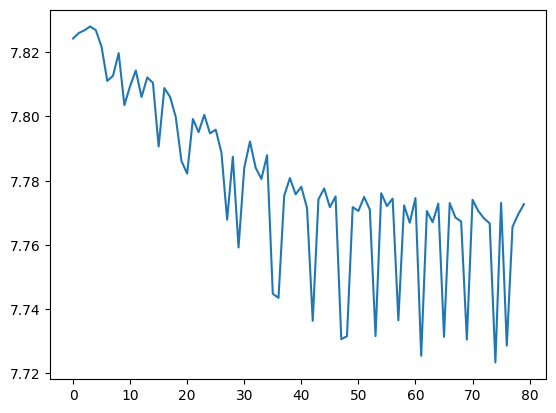

In [ ]:
plt.plot(losses)

In [ ]:
def test():
    ds_size = len(train_dataloader.dataset)
    num_batches = len(train_dataloader)
    model.eval()
    predictor.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for (x,sizes), y in train_dataloader:
            embds= model(x,sizes)[0]
            mask = torch.zeros_like(embds).to(device)
            for i, size in enumerate(sizes):
                mask[i, size-1, :] = 1
            embds = torch.masked_select(embds, mask.bool()).view(sizes.size(0), embds.size(2)).detach()
            preds = predictor(embds)

            test_loss += criterion(preds, y).item()
            correct += (preds.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= ds_size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
test()

Test Error: 
 Accuracy: 3.8%, Avg loss: 10.345545 



In [ ]:
import torch
torch.save(model.state_dict(), "LSTM weights new.pt")
# torch.save(predictor.state_dict(), "predictor weights 100 pers accuracy.pt")

In [ ]:
predictor.load_state_dict(torch.load("predictor weights 100 pers accuracy.pt"))
predictor.eval()

NeuralPredictor(
  (model): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=1024, out_features=2500, bias=True)
  )
)

In [ ]:
def predict_movie(description: str) -> int:
    tokens = tokenizer.encode(description).tokens
    vectors = torch.tensor(np.stack([word2vec.wv.get_vector(token) for token in tokens])).to(device)

    model.eval()
    predictor.eval()

    sizes = torch.tensor([len(tokens)]).to(device)

    embds= model(vectors.unsqueeze(0), sizes)[0]
    mask = torch.zeros_like(embds).to(device)
    for i, size in enumerate(sizes):
        mask[i, size-1, :] = 1
    embds = torch.masked_select(embds, mask.bool()).view(sizes.size(0), embds.size(2)).detach()
    preds = predictor(embds)[0]
    return torch.argmax(preds).item()

In [ ]:
index = predict_movie("1987 год. Джордан Белфорт становится брокером в успешном инвестиционном банке. Вскоре банк закрывается после внезапного обвала индекса Доу-Джонса. По совету жены Терезы Джордан устраивается в небольшое заведение, занимающееся мелкими акциями. Его настойчивый стиль общения с клиентами и врождённая харизма быстро даёт свои плоды. Он знакомится с соседом по дому Донни, торговцем, который сразу находит общий язык с Джорданом и решает открыть с ним собственную фирму. В качестве сотрудников они нанимают нескольких друзей Белфорта, его отца Макса и называют компанию «Стрэттон Оукмонт». В свободное от работы время Джордан прожигает жизнь: лавирует от одной вечеринки к другой, вступает в сексуальные отношения с проститутками, употребляет множество наркотических препаратов, в том числе кокаин и кваалюд. Однажды наступает момент, когда быстрым обогащением Белфорта начинает интересоваться агент ФБР...")
movie_df.iloc[index]["name"]

'Самогонщики'

In [ ]:
movie_df.iloc[index]

'Месть от кутюр'

In [ ]:
movie_df.description[2]

'1987 год. Джордан Белфорт становится брокером в успешном инвестиционном банке. Вскоре банк закрывается после внезапного обвала индекса Доу-Джонса. По совету жены Терезы Джордан устраивается в небольшое заведение, занимающееся мелкими акциями. Его настойчивый стиль общения с клиентами и врождённая харизма быстро даёт свои плоды. Он знакомится с соседом по дому Донни, торговцем, который сразу находит общий язык с Джорданом и решает открыть с ним собственную фирму. В качестве сотрудников они нанимают нескольких друзей Белфорта, его отца Макса и называют компанию «Стрэттон Оукмонт». В свободное от работы время Джордан прожигает жизнь: лавирует от одной вечеринки к другой, вступает в сексуальные отношения с проститутками, употребляет множество наркотических препаратов, в том числе кокаин и кваалюд. Однажды наступает момент, когда быстрым обогащением Белфорта начинает интересоваться агент ФБР...'

# Transformer